<a href="https://colab.research.google.com/github/revaan-mishra/Directing-Customers-to-Subscription-Through-App-Behavior-Analysis/blob/main/Directing_Customers_to_Subscription_Through_App_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Required Libraries ###

In [3]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [4]:
dataset = pd.read_csv('appdata10.csv')

### EDA ###

In [5]:
dataset.head(10)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1
5,56480,2013-04-03 09:58:15.752,2,09:00:00,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,2013-04-03 09:59:03.291,0
6,144649,2012-12-25 02:33:18.461,1,02:00:00,35,"product_review,product_review2,ScanPreview",3,0,0,0,NaN,0
7,249366,2012-12-11 03:07:49.875,1,03:00:00,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,NaN,0
8,372004,2013-03-20 14:22:01.569,2,14:00:00,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,1,2013-04-27 22:24:54.542,0
9,338013,2013-04-26 18:22:16.013,4,18:00:00,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,2013-04-26 18:31:58.923,0


In [6]:
dataset.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


### First set of Feature cleaning

In [7]:
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

In [8]:
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])

In [9]:
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


### Plotting Histograms

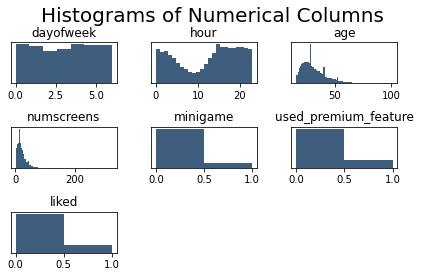

In [10]:
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Correlation with Response Variable

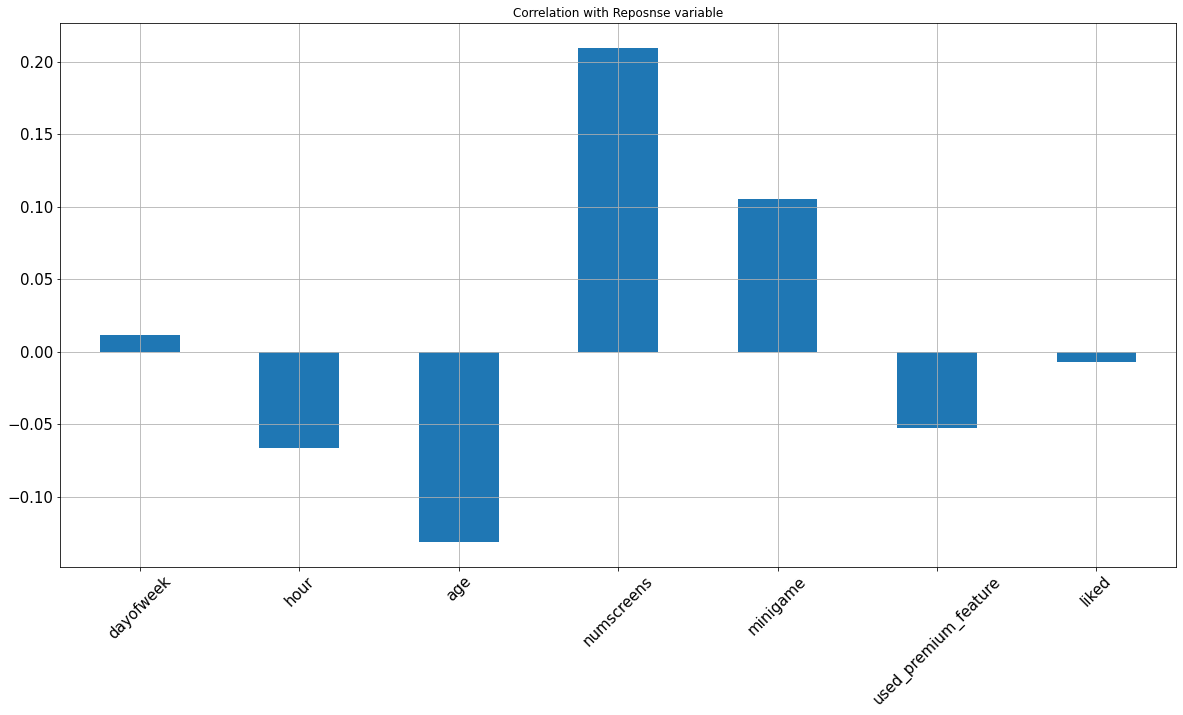

In [11]:
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)

### Setting up Correlation matrix

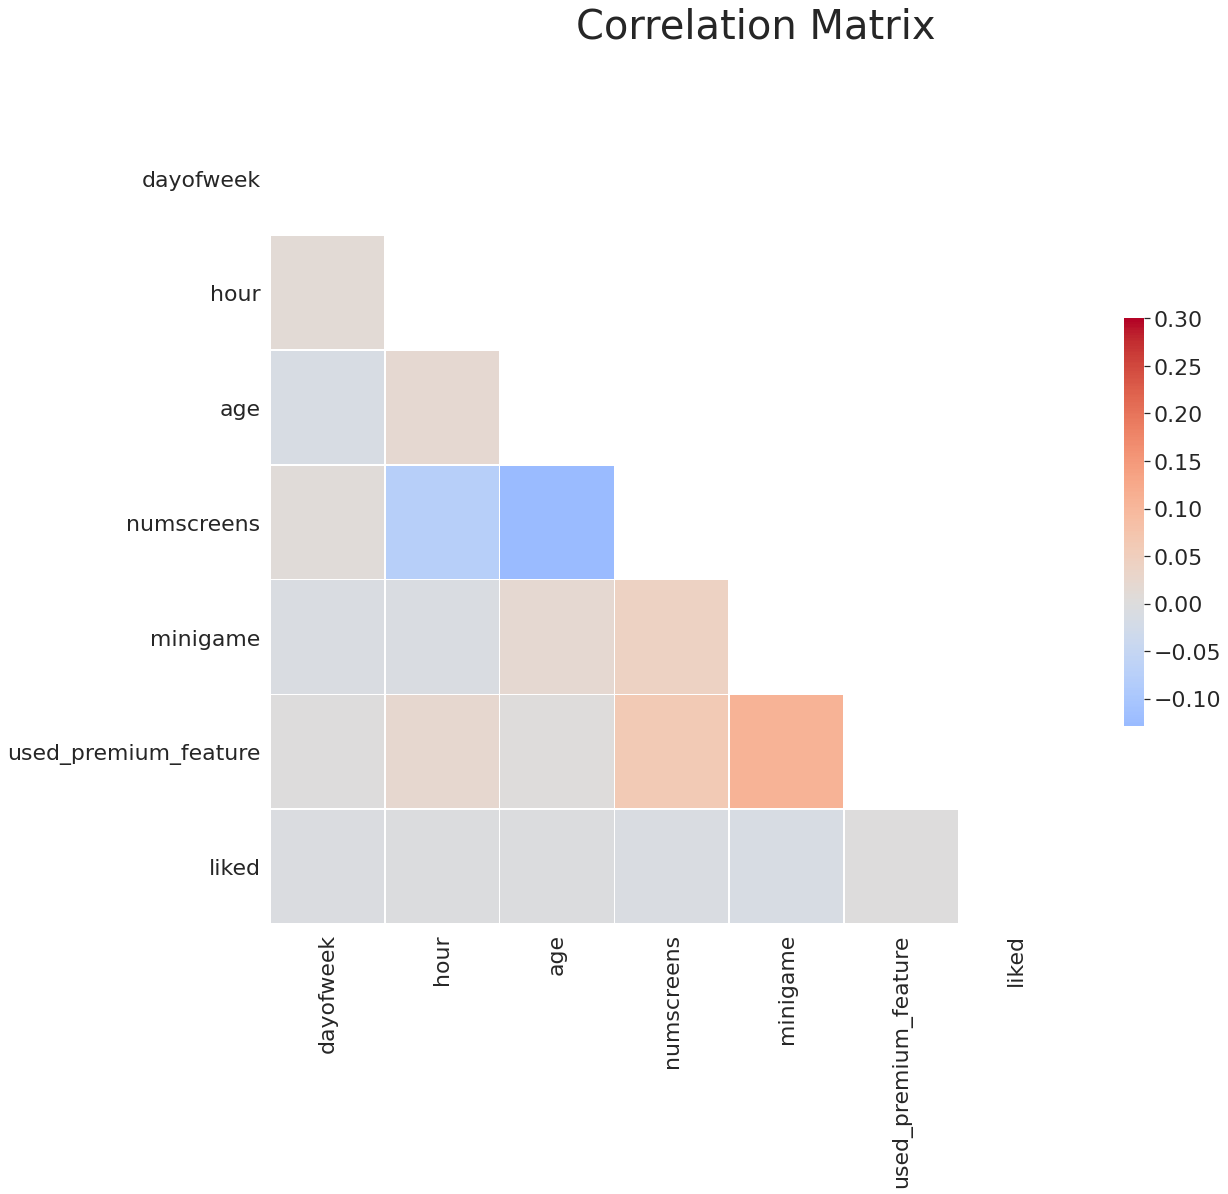

In [12]:
sn.set(style="white", font_scale=2)
corr = dataset2.corr()

mask = np.zeros_like(corr, dtype=np.bool)   # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 15))      # Setting up the figure
f.suptitle("Correlation Matrix", fontsize = 40)

cmap = sn.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap

sn.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,   # Draw the heatmap with the mask and correct aspect ratio
        square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Feature Engineering

#### Formatting Date Columns

In [13]:
dataset.dtypes
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

#### Selecting Time For Response

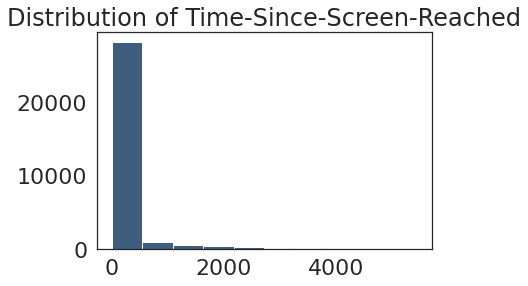

In [14]:
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

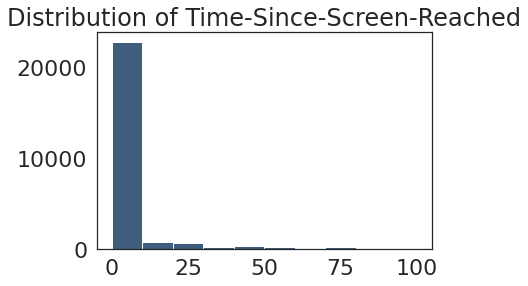

In [15]:
plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

##### Since most of the users lie between 0-48, we're going to nullify the remaining entries

In [16]:
dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

### Formatting the screen_list Field

#### Load Top Screens

In [17]:
top_screens = pd.read_csv('top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

#### Mapping Screens to Fields

In [18]:
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

#### Funnels

In [19]:
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

In [20]:
cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

In [21]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

In [22]:
loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

#### Saving Our Result Dataset ####

In [23]:
dataset.head()
dataset.to_csv('new_appdata10.csv', index = False)

## Creating our Model

### Data Preprocessing

#### Splitting Independent and Response Variables

In [24]:
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

#### Splitting the dataset into the Training set and Test set

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

#### Balancing the Training Set

In [26]:
import random
y_train.value_counts()

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
   higher = pos_index
   lower = neg_index
else:
   higher = neg_index
   lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

#### Removing Identifiers

In [27]:
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

#### Feature Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

### Model Building ####

### Fitting Model to the Training Set

In [29]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l2')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predicting Test Set

In [30]:
y_pred = classifier.predict(X_test)

### Evaluating Results

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

0.7652681356273267

Test Data Accuracy: 0.7667


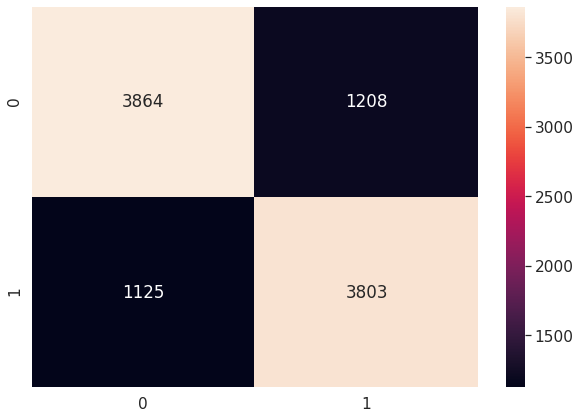

In [32]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

### Applying k-Fold Cross Validation

In [33]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.769 (+/- 0.012)


### Analyzing Coefficients

In [34]:
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,dayofweek,0.033065
1,hour,0.015287
2,age,-0.149296
3,numscreens,-0.089127
4,minigame,-0.034741
5,used_premium_feature,-0.063126
6,liked,0.020408
7,location,-0.039712
8,Institutions,-0.069842
9,VerifyPhone,0.664949


## Model Tuning ####

### Grid Search (Round 1)

In [35]:
from sklearn.model_selection import GridSearchCV  # Grid Search (Round 1)
penalty = ['l1', 'l2']                            # Select Regularization Method
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]          # Create regularization hyperparameter space       

#### Combine Parameters

In [36]:
parameters = dict(C=C, penalty=penalty)
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)

In [37]:
import time
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 13.22 seconds


In [38]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

(0.7693756393201413, {'C': 0.1, 'penalty': 'l2'})

### Grid Search (Round 2)

In [39]:
# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

In [40]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 10.69 seconds


In [41]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_

0.7694007208255859

## Formatting Final Results

In [42]:
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [43]:
print(final_results)

        user  enrolled  predicted_reach
0     239786         1                1
1     279644         1                1
2      98290         0                0
3     170150         1                1
4     237568         1                1
...      ...       ...              ...
9995  143036         1                0
9996   91158         1                1
9997  248318         0                0
9998  142418         1                1
9999  279355         1                1

[10000 rows x 3 columns]


## Accuracy with Other Machine Learning classifiers

### Decision Tree Classifier

In [44]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion= 'entropy', random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.6949

### K – Nearest Neighbor Classifier

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2,)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
 
accuracy_score(y_test, y_pred_knn)

0.7142

### Naive Bayes

In [46]:

from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
 
accuracy_score(y_test, y_pred_nb)

0.7134

### Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
 
accuracy_score(y_test, y_pred_rf)

0.7599

### Support Vector Machine

In [48]:

from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
 
accuracy_score(y_test, y_pred_svc)

0.7752

# X----- END----X